In [1]:
from __future__ import division, print_function

import os
from datetime import datetime

# Ignore warnings
import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from skimage import io, transform
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, utils
from sklearn.metrics import average_precision_score, accuracy_score

warnings.filterwarnings("ignore")


import copy
import os
import time

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.optim import lr_scheduler
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, models, transforms
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter
import random
import albumentations as A
from math import ceil
from collections import Counter

In [2]:
# import sys
# sys.path.append("../")

# %load_ext autoreload
# %autoreload 2

### Prepare data

In [3]:
data_folder = "../data/3rd_chest-xray-covid19-pneumonia"

In [4]:
dataset = torchvision.datasets.ImageFolder(root=data_folder, 
                                 transform = None,
                                 target_transform = None,
                                 )

In [5]:
len(dataset)

6432

In [6]:
Counter(dataset.targets)

Counter({0: 1583, 1: 4849})

In [7]:
def visualize_classes(dataset: Dataset, classes: list = [0, 1], columns: int = 6, inv_normalize = None):
    np.random.seed(0)
    classes_ids = [[] for _ in range(len(classes))]
    for i, class_ in enumerate(classes):
        for _ in range(columns):
            id_ = np.random.randint(len(dataset), size=1)[0]
            while dataset[id_][1] != class_:
                id_ = np.random.randint(len(dataset), size=1)[0]
            classes_ids[i].append(id_)
    f, ax = plt.subplots(len(classes), columns)
    f.set_size_inches(18.5, 10.5)
    for i in range(len(classes)):
        for j in range(columns):
            ax[i, j].set_title(f"id - {classes_ids[i][j]}; label - {dataset[classes_ids[i][j]][1]}")
            image = dataset[classes_ids[i][j]][0]
            if inv_normalize is not None:
                image = inv_normalize(image)
            if isinstance(image, torch.Tensor):
                image = image.permute(1, 2, 0).numpy()
            ax[i, j].imshow(image)
            ax[i, j].axis('off')

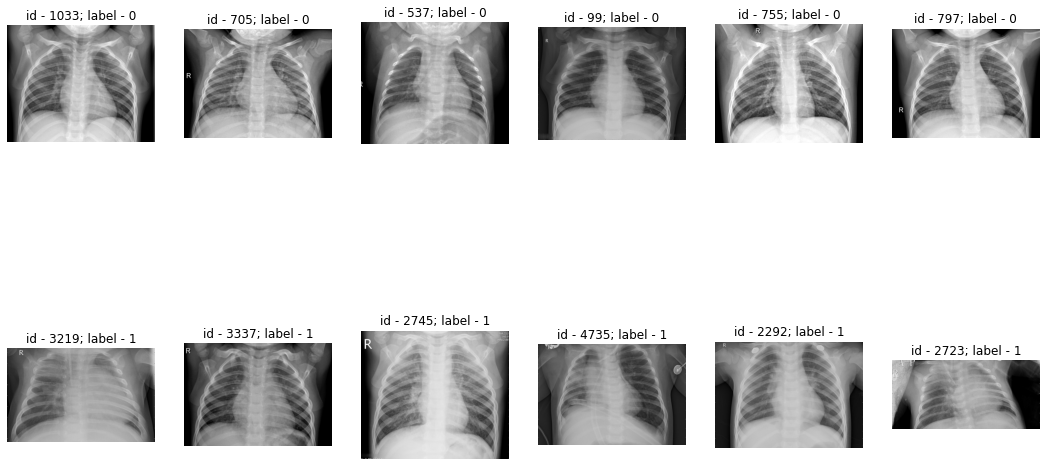

In [8]:
visualize_classes(dataset)

In [9]:
dataset = torchvision.datasets.ImageFolder(
    root=data_folder, 
    transform = transforms.Compose(
        [
            transforms.Resize((224, 224)),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    ),
    target_transform = None,
)

In [10]:
inv_normalize = transforms.Compose([
    transforms.Normalize(mean = [ 0., 0., 0. ], std = [ 1/0.229, 1/0.224, 1/0.225 ]),
    transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ], std = [ 1., 1., 1. ]),
])

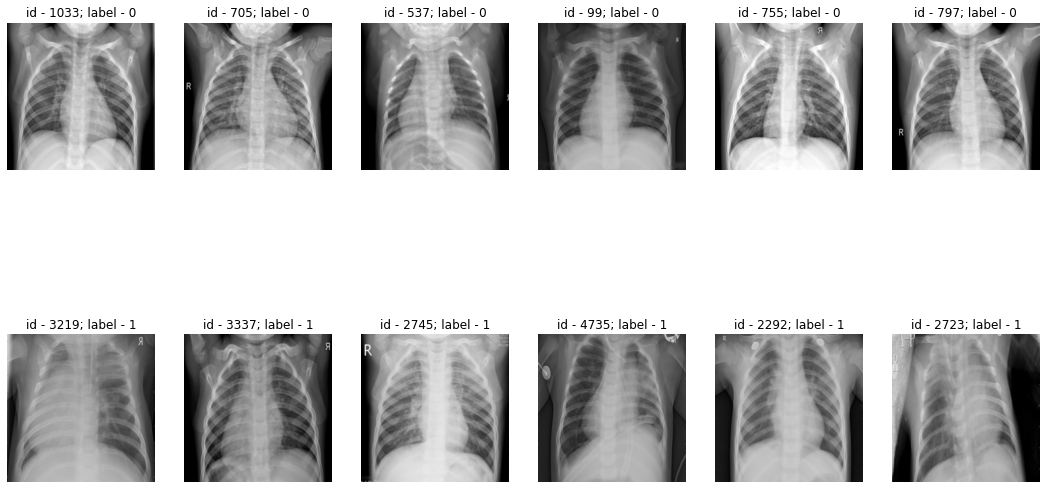

In [11]:
visualize_classes(dataset, inv_normalize=inv_normalize)

In [12]:
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(
    dataset, [train_size, test_size], torch.Generator().manual_seed(0)
)

In [22]:
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=32, shuffle=True, num_workers=0
)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=32, shuffle=True, num_workers=0
)

In [23]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
images.shape, labels.shape

(torch.Size([32, 3, 224, 224]), torch.Size([32]))

### Train model

In [24]:
def epoch(loader, model, device, criterion, opt=None):
    probabilities = []
    all_labels = []
    total_loss = 0
    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        if opt:
            opt.zero_grad()
            loss.backward()
            opt.step()

        total_loss += loss.item() * inputs.size(0)
        all_labels.extend(list(labels.cpu().detach().numpy().reshape(-1)))
        probabilities.extend(list(outputs.cpu().detach().numpy()[:, 1].reshape(-1)))
    return total_loss / float(len(loader.dataset)), all_labels, probabilities

In [25]:
def print_metrics(writer, phase, epoch_num, loss, labels, prob, lr=None):
    acc = accuracy_score(labels, (np.array(prob) > 0.5).astype(int))
    ap = average_precision_score(labels, prob)

    writer.add_scalar(f'Loss', loss, epoch_num)
    writer.add_scalar(f'Accuracy', acc, epoch_num)
    writer.add_scalar(f'Average precision', ap, epoch_num)
    if lr is not None:
        writer.add_scalar(f'LR', lr, epoch_num)
        print(f"{phase} Loss: {loss:.4f} Acc: {acc:.4f} AP: {ap:.4f} LR: {lr}")
    else:
        print(f"{phase} Loss: {loss:.4f} Acc: {acc:.4f} AP: {ap:.4f}")

In [26]:
def create_writers(log_dir: str = "./runs"):
    current_time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    train_log_dir = f"{log_dir}/{current_time}/train/"
    val_log_dir = f"{log_dir}/{current_time}/val/"
    train_writer = SummaryWriter(log_dir=train_log_dir)
    val_writer = SummaryWriter(log_dir=val_log_dir)
    return train_writer, val_writer

In [27]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 100.0
    best_epoch = 0
    train_writer, val_writer = create_writers("../runs")
    model.train()

    for epoch_num in range(num_epochs):
        print(f"Epoch {epoch_num}/{num_epochs - 1}")
        print("-" * 10)

        train_loss, train_labels, train_prob = epoch(train_loader, model, device, criterion, opt = optimizer)
        val_loss, val_labels, val_prob = epoch(test_loader, model, device, criterion)

        print_metrics(train_writer, "train", epoch_num, train_loss, train_labels, train_prob, optimizer.param_groups[0]["lr"])
        print_metrics(val_writer, "val", epoch_num, val_loss, val_labels, val_prob)

        scheduler.step(val_loss)

        if val_loss < best_loss:
            best_loss = val_loss
            best_epoch = epoch_num
            best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f"Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s")
    print(f"Best val loss: {best_loss:4f} Best epoch: {best_epoch}")

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [31]:
device = "cuda:0"
# device = "cpu"

In [32]:
model_ft = models.resnet18(pretrained=True)

model_ft.fc = nn.Sequential(
    nn.Linear(model_ft.fc.in_features, 2),
    nn.Softmax(),
)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.001, weight_decay=0.001)

exp_lr_scheduler = lr_scheduler.ReduceLROnPlateau(optimizer_ft, 'min', patience=5, eps=1e-07)

In [33]:
model_ft = train_model(
    model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=15
)

Epoch 0/14
----------
train Loss: 0.3952 Acc: 0.9121 AP: 0.9802 LR: 0.001
val Loss: 0.3848 Acc: 0.9277 AP: 0.9797

Epoch 1/14
----------
train Loss: 0.3812 Acc: 0.9304 AP: 0.9826 LR: 0.001
val Loss: 0.3916 Acc: 0.9176 AP: 0.9708

Epoch 2/14
----------
train Loss: 0.3836 Acc: 0.9258 AP: 0.9793 LR: 0.001
val Loss: 0.3657 Acc: 0.9479 AP: 0.9821

Epoch 3/14
----------
train Loss: 0.3841 Acc: 0.9254 AP: 0.9830 LR: 0.001
val Loss: 0.3838 Acc: 0.9301 AP: 0.9838

Epoch 4/14
----------
train Loss: 0.3886 Acc: 0.9234 AP: 0.9737 LR: 0.001
val Loss: 0.4282 Acc: 0.8803 AP: 0.9467

Epoch 5/14
----------
train Loss: 0.3907 Acc: 0.9207 AP: 0.9701 LR: 0.001
val Loss: 0.3901 Acc: 0.9161 AP: 0.9832

Epoch 6/14
----------
train Loss: 0.3856 Acc: 0.9271 AP: 0.9770 LR: 0.001
val Loss: 0.3819 Acc: 0.9293 AP: 0.9768

Epoch 7/14
----------
train Loss: 0.3872 Acc: 0.9238 AP: 0.9787 LR: 0.001
val Loss: 0.3735 Acc: 0.9386 AP: 0.9733

Epoch 8/14
----------
train Loss: 0.3797 Acc: 0.9293 AP: 0.9798 LR: 0.001
val Lo

### Analyze results

In [34]:
val_image = []
val_true = []
val_pred = []
val_prob = []
model_ft.eval()
with torch.no_grad():
    for inputs, batch_labels in tqdm(test_loader):
        inputs = inputs.to("cuda:0")
        outputs = model_ft(inputs)
        prob = outputs.to("cpu").numpy()[:, 1]
        preds = (prob > 0.5).astype(int)
        val_prob.extend(prob)
        val_pred.extend(preds)
        val_true.extend(batch_labels.to("cpu").numpy())
        val_image.extend(inputs.to("cpu"))

100%|██████████| 41/41 [00:44<00:00,  1.08s/it]


In [35]:
def error_class(row):
    if row["true"] == row["pred"] == 1:
        return "TP"
    elif row["true"] == row["pred"] == 0:
        return "TN"
    elif row["true"] != row["pred"] and row["pred"] == 1:
        return "FP"
    else:
        return "FN"

In [36]:
df = pd.DataFrame({"true": val_true, "pred": val_pred, "prob": val_prob})

In [37]:
df["error_type"] = df.apply(error_class, axis=1)

In [38]:
df.groupby("error_type").count()

,true,pred,prob
error_type,,,
FN,21,21,21
FP,42,42,42
TN,287,287,287
TP,937,937,937


In [39]:
print(f"accuracy_score - {accuracy_score(df['true'], df['pred'])}")
print(f"average_precision_score - {average_precision_score(df['true'], df['pred'])}")

accuracy_score - 0.951048951048951
average_precision_score - 0.952435845764644


In [40]:
n = 10
def view_images(df: pd.DataFrame, images: np.ndarray, columns: int = 5, fig_size: tuple = (18.5, 10.5)):
    f, ax = plt.subplots(ceil(df.shape[0] / columns), columns)
    f.set_size_inches(*fig_size)
    for i, (id_, row) in enumerate(df.iterrows()):
        if ax.ndim  == 2:
            current_ax = ax[i // columns, i % columns]
        else:
            current_ax = ax[i]
        current_ax.set_title(str(row))
        current_ax.imshow(inv_normalize(images[id_]).permute(1, 2, 0).numpy())
        current_ax.axis('off')

In [41]:
df

,true,pred,prob,error_type
0,1,1,9.997439e-01,TP
1,0,0,3.211579e-06,TN
2,1,1,9.997193e-01,TP
3,1,1,9.997409e-01,TP
4,0,1,8.005491e-01,FP
...,...,...,...,...
1282,0,0,9.541792e-07,TN
1283,1,1,9.996945e-01,TP
1284,1,1,9.997323e-01,TP
1285,1,1,9.997415e-01,TP


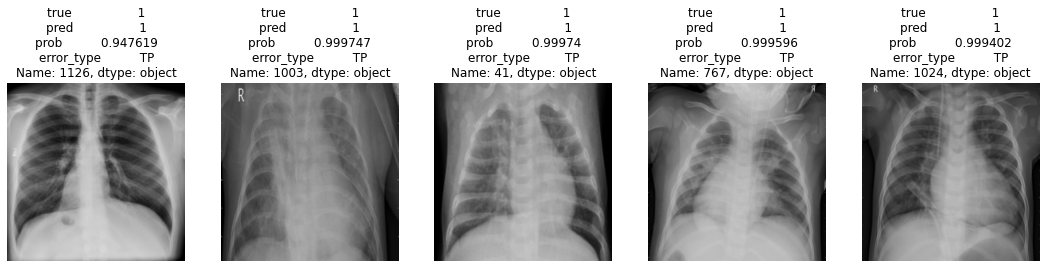

In [42]:
view_images(df[df["error_type"]=="TP"].sample(5), val_image)

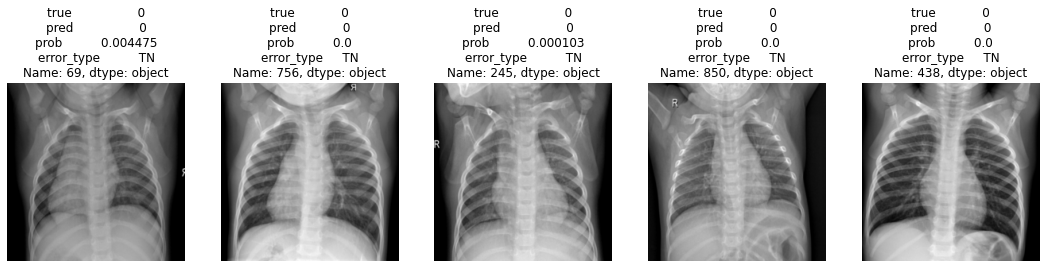

In [43]:
view_images(df[df["error_type"]=="TN"].sample(5), val_image)

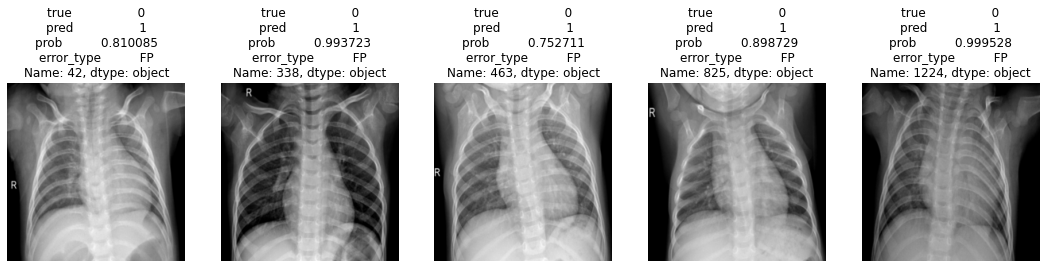

In [44]:
view_images(df[df["error_type"]=="FP"].sample(5), val_image)

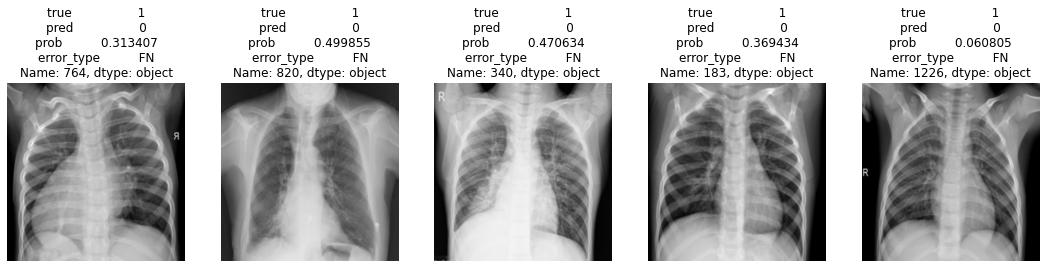

In [45]:
view_images(df[df["error_type"]=="FN"].sample(5), val_image)

### Save model

In [46]:
save_path = f"../models/4.4_resnet18_{datetime.now().strftime('%Y-%m-%d_%H:%M:%S')}.pt"
torch.save(model_ft.state_dict(), save_path)
save_path

'../models/4.4_resnet18_2021-04-28_22:46:52.pt'

In [47]:
model = models.resnet18()
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 2),
    nn.Softmax(),
)

model.load_state_dict(torch.load(save_path))
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  